In [2]:
import torch
from torch import nn
from pathlib import Path
import gzip, pickle
import torch.nn.functional as F

#### load  data

In [3]:
DATA_FOLDER = Path('data')
DATA_FILE = DATA_FOLDER/'mnist.pkl.gz'

In [4]:
with gzip.open(DATA_FILE, 'rb') as f:
    data = pickle.load(f, encoding='latin')

In [5]:
((x_train, y_train), (x_val, y_val), _) = data

In [6]:
(x_train, y_train, x_val, y_val) = map(torch.tensor, (x_train, y_train, x_val, y_val))

In [7]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

#### model

In [137]:
nin, nh, nout = x_train.shape[1], 50, 10

In [138]:
class Model(nn.Module):
    def __init__(self, nin, nh, nout):
        super().__init__()
        self.layers = [nn.Linear(nin, nh), nn.ReLU(nh), nn.Linear(nh, nout)]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [139]:
model = Model(nin, nh, nout)

In [140]:
pred = model(x_train)

In [141]:
pred.shape

torch.Size([50000, 10])

In [142]:
pred

tensor([[ 2.3653e-01,  5.7953e-04, -1.8526e-01,  ..., -1.1290e-03,
          1.0068e-01, -1.2474e-01],
        [ 2.2510e-01, -9.3672e-02, -2.3261e-01,  ...,  5.9222e-02,
          1.9832e-02, -8.4995e-02],
        [ 1.9867e-01, -1.5230e-01, -6.5086e-02,  ...,  1.8481e-02,
         -1.1236e-02, -1.4206e-01],
        ...,
        [ 2.4863e-01, -2.2664e-01, -9.7118e-02,  ..., -1.3454e-01,
          1.5280e-01, -1.7664e-01],
        [ 2.1275e-01, -1.0548e-01, -3.1598e-02,  ..., -3.2585e-02,
          9.3807e-02, -1.0054e-01],
        [ 1.9768e-01, -1.7176e-01, -1.0908e-01,  ...,  2.7064e-05,
          3.1564e-02, -8.3367e-02]], grad_fn=<AddmmBackward0>)

In [147]:
def log_softmax(x):
    return (x.exp()/ x.exp().sum(-1, keepdim=True)).log()

In [148]:
log_softmax(pred)

tensor([[-2.1122, -2.3481, -2.5340,  ..., -2.3498, -2.2480, -2.4735],
        [-2.1032, -2.4220, -2.5609,  ..., -2.2691, -2.3085, -2.4133],
        [-2.1102, -2.4612, -2.3740,  ..., -2.2904, -2.3201, -2.4509],
        ...,
        [-2.0636, -2.5389, -2.4094,  ..., -2.4468, -2.1595, -2.4889],
        [-2.1168, -2.4350, -2.3611,  ..., -2.3621, -2.2357, -2.4301],
        [-2.1254, -2.4949, -2.4322,  ..., -2.3231, -2.2916, -2.4065]],
       grad_fn=<LogBackward0>)

In [149]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [150]:
logsumexp(pred)

tensor([2.3487, 2.3283, 2.3089,  ..., 2.3123, 2.3295, 2.3231],
       grad_fn=<AddBackward0>)

In [151]:
def logsumexp_pyt(x):
    return x - x.logsumexp(-1, keepdim=True)

In [152]:
logsumexp_pyt(pred)

tensor([[-2.1122, -2.3481, -2.5340,  ..., -2.3498, -2.2480, -2.4735],
        [-2.1032, -2.4220, -2.5609,  ..., -2.2691, -2.3085, -2.4133],
        [-2.1102, -2.4612, -2.3740,  ..., -2.2904, -2.3201, -2.4509],
        ...,
        [-2.0636, -2.5389, -2.4094,  ..., -2.4468, -2.1595, -2.4889],
        [-2.1168, -2.4350, -2.3611,  ..., -2.3621, -2.2357, -2.4301],
        [-2.1254, -2.4949, -2.4322,  ..., -2.3231, -2.2916, -2.4065]],
       grad_fn=<SubBackward0>)

In [153]:
torch.allclose(log_softmax(pred), logsumexp_pyt(pred))

True

In [155]:
y_train[:3]

tensor([5, 0, 4])

In [156]:
sm_pred = logsumexp_pyt(pred)

In [159]:
sm_pred.shape

torch.Size([50000, 10])

In [163]:
sm_pred[0, 5], sm_pred[1, 0], sm_pred[2, 4]

(tensor(-2.2889, grad_fn=<SelectBackward0>),
 tensor(-2.1032, grad_fn=<SelectBackward0>),
 tensor(-2.1724, grad_fn=<SelectBackward0>))

In [166]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.2889, -2.1032, -2.1724], grad_fn=<IndexBackward0>)

In [167]:
def nll(input, target):
    return - input[range(target.shape[0]), target].mean()

In [169]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3053, grad_fn=<NegBackward0>)

In [179]:
pred.shape

torch.Size([50000, 10])

In [180]:
F.log_softmax(pred, -1)

tensor([[-2.1122, -2.3481, -2.5340,  ..., -2.3498, -2.2480, -2.4735],
        [-2.1032, -2.4220, -2.5609,  ..., -2.2691, -2.3085, -2.4133],
        [-2.1102, -2.4612, -2.3740,  ..., -2.2904, -2.3201, -2.4509],
        ...,
        [-2.0636, -2.5389, -2.4094,  ..., -2.4468, -2.1595, -2.4889],
        [-2.1168, -2.4350, -2.3611,  ..., -2.3621, -2.2357, -2.4301],
        [-2.1254, -2.4949, -2.4322,  ..., -2.3231, -2.2916, -2.4065]],
       grad_fn=<LogSoftmaxBackward0>)

In [182]:
torch.allclose(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

True

In [183]:
torch.allclose(F.cross_entropy(pred, y_train), loss)

True

In [193]:
bs = 50

In [194]:
xb = x_train[0:bs]
xb.shape

torch.Size([50, 784])

In [195]:
yb = y_train[0:bs]
yb.shape

torch.Size([50])

In [196]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3])

In [197]:
pred = model(xb)

In [198]:
pred.shape

torch.Size([50, 10])

tensor(0.0800)

In [228]:
lr = 0.5
epoches = 5
n = x_train.shape[0]

In [229]:
get_loss = F.cross_entropy

In [40]:
def accuracy(pred, target):
    return (pred.argmax(1) == target).float().mean()

In [41]:
def report(loss, pred, target):
    return print(f'loss:{loss:.2f}, accuracy:{accuracy(pred, target):.2f}')

In [241]:
xb,yb = x_train[0:bs], y_train[0:bs]
model = Model(nin, nh, nout)
pred = model(xb)
loss = get_loss(pred, yb)
report(loss, pred, yb)

loss:2.33, accuracy:0.02


In [242]:
for epoch in range(epoches):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb,yb = x_train[s], y_train[s]
        pred = model(xb)
        loss = get_loss(pred, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= lr * l.weight.grad
                    l.bias -= lr * l.bias.grad
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, pred, yb)

loss:0.14, accuracy:0.94
loss:0.10, accuracy:1.00
loss:0.05, accuracy:1.00
loss:0.05, accuracy:0.98
loss:0.04, accuracy:1.00


In [243]:
pred.argmax(1)

tensor([5, 2, 0, 0, 0, 3, 9, 5, 7, 6, 6, 1, 2, 8, 1, 6, 3, 4, 3, 6, 6, 0, 1, 9,
        0, 2, 2, 6, 7, 4, 7, 3, 4, 9, 9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8,
        4, 8])

In [244]:
yb

tensor([5, 2, 0, 0, 0, 3, 9, 5, 7, 6, 6, 1, 2, 8, 1, 6, 3, 4, 3, 6, 6, 0, 1, 9,
        0, 2, 2, 6, 7, 4, 7, 3, 4, 9, 9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8,
        4, 8])

In [245]:
from functools import reduce

In [248]:
t = [1, 2, 3, 5]

In [249]:
reduce(lambda val, op: val + op, t, 0)

11

#### params and optim

In [10]:
m1 = nn.Module()

In [12]:
m1.foo = nn.Linear(3, 4)

In [19]:
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [21]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [22]:
print(nn.Module)

<class 'torch.nn.modules.module.Module'>


In [23]:
nn.Module??

In [24]:
class MLP(nn.Module):
    def __init__(self, nin, nh, nout):
        super().__init__()
        self.l1 = nn.Linear(nin, nh)
        self.l2 = nn.Linear(nh, nout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [38]:
n = x_train.shape[1]
m = x_train.shape[0]
nh = 50
no = 10
epoches = 3
lr = 0.5
bs = 50

In [29]:
model = MLP(n, nh, no)

In [30]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [32]:
for name, l in model.named_children():
    print(f"name: {name}, l: {l}")

name: l1, l: Linear(in_features=784, out_features=50, bias=True)
name: l2, l: Linear(in_features=50, out_features=10, bias=True)
name: relu, l: ReLU()


In [33]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [43]:
def fit():
    for epoch in range(epoches):
        for i in range(0, m, bs):
            s = slice(i, min(m, i+bs))
            xb, yb = x_train[s], y_train[s]
            pred = model(xb)
            loss = F.cross_entropy(pred, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad()
        
        report(loss, pred, yb)              

In [44]:
fit()

loss:0.12, accuracy:0.94
loss:0.10, accuracy:0.94
loss:0.08, accuracy:0.96


In [50]:
class MyModule():
    def __init__(self, nin, nh, nout):
        self._modules = {}
        self.l1 = nn.Linear(nin, nh)
        self.l2 = nn.Linear(nh, nout)
    
    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self):
        return (f'{self._modules}')
    
    def parameters(self):
        for m in self._modules.values():
            yield from m.parameters()

In [51]:
m1 = MyModule(n, nh, no)

In [52]:
m1

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [55]:
for p in m1.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


#### registering modules

In [58]:
from functools import reduce

In [100]:
layers = [nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, no)]

In [71]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(layers):
            self.add_module(f'layer_{i}', l)
    
    def forward(self, x):
        return reduce(lambda x, l: l(x), self.layers, x)

In [72]:
model = Model(layers)

In [73]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [75]:
model(x_train).shape

torch.Size([50000, 10])

#### nn.ModuleList

In [76]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [77]:
model = SequentialModel(layers)

In [78]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [79]:
fit()

loss:0.14, accuracy:0.96
loss:0.09, accuracy:0.96
loss:0.07, accuracy:0.98


#### nn.Sequential

In [82]:
model = nn.Sequential(*layers)

In [83]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [84]:
fit()

loss:0.06, accuracy:0.98
loss:0.07, accuracy:0.98
loss:0.05, accuracy:1.00


#### optim

In [101]:
class Optimizer():
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [102]:
model = nn.Sequential(*layers)

In [103]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [104]:
optim = Optimizer(model.parameters(), lr)

In [105]:
for epoch in range(epoches):
    for i in range(0, m, bs):
        s = slice(i, min(m, i+bs))
        xb, yb = x_train[s], y_train[s]
        pred = model(xb)
        loss = F.cross_entropy(pred, yb)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
    report(loss, pred, yb)

loss:0.12, accuracy:0.96
loss:0.07, accuracy:1.00
loss:0.09, accuracy:0.96


#### optim.SGD

In [106]:
from torch import optim

In [116]:
def get_model():
    layers = [nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, no)]
    model = nn.Sequential(*layers)
    opt = optim.SGD(model.parameters(), lr) 
    return model, opt

In [117]:
model, opt = get_model()

In [118]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [119]:
for epoch in range(epoches):
    for i in range(0, m, bs):
        s = slice(i, min(m, i+bs))
        xb, yb = x_train[s], y_train[s]
        pred = model(xb)
        loss = F.cross_entropy(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    report(loss, pred, yb)

loss:0.17, accuracy:0.92
loss:0.19, accuracy:0.94
loss:0.12, accuracy:0.96


#### datasets and dataloader

In [121]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [122]:
train_ds, val_ds = Dataset(x_train, y_train), Dataset(x_val, y_val) 

In [124]:
assert len(x_train) == len(train_ds)
assert len(x_val) == len(val_ds)

In [127]:
xb, yb = train_ds[0:5]

In [128]:
xb.shape

torch.Size([5, 784])

In [129]:
yb.shape

torch.Size([5])

In [130]:
model, opt = get_model()

In [131]:
for epoch in range(epoches):
    for i in range(0, m, bs):
        s = slice(i, min(m, i+bs))
        xb, yb = train_ds[s]
        pred = model(xb)
        loss = F.cross_entropy(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    report(loss, pred, yb)

loss:0.17, accuracy:0.94
loss:0.12, accuracy:0.96
loss:0.11, accuracy:0.96


#### dataloader

In [144]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
    
    def __iter__(self):
        for i in range(0, len(self.ds), bs):
            yield self.ds[i: i+self.bs]

In [145]:
train_dl = DataLoader(train_ds, bs)
val_dl = DataLoader(val_ds, bs)

In [146]:
xb, yb = next(iter(train_dl))

In [147]:
import matplotlib.pyplot as plt

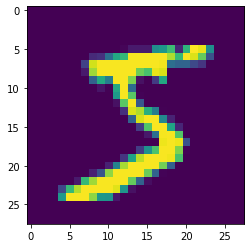

In [148]:
plt.imshow(xb[0].view(28, 28))

In [149]:
model, opt = get_model()

In [150]:
for epoch in range(epoches):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = F.cross_entropy(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    report(loss, pred, yb)

loss:0.13, accuracy:0.96
loss:0.11, accuracy:0.96
loss:0.07, accuracy:0.98


#### random sampling

In [165]:
import random
from itertools import islice
import fastcore.all as fc

In [158]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle
    
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [159]:
s = Sampler(train_ds)

In [162]:
list(iter(s))[:4]

[0, 1, 2, 3]

In [163]:
s = Sampler(train_ds, True)

In [164]:
list(iter(s))[:4]

[29118, 3418, 43685, 23876]

In [166]:
fc.chunked??

In [180]:
t = torch.arange(6)

In [181]:
t

tensor([0, 1, 2, 3, 4, 5])

In [183]:
list(fc.chunked(t, 3, drop_last=True))

[[tensor(0), tensor(1), tensor(2)], [tensor(3), tensor(4), tensor(5)]]

In [185]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False):
        fc.store_attr()
    
    def __iter__(self):
        yield from fc.chunked(self.sampler, self.bs, drop_last = self.drop_last)

In [187]:
batch = BatchSampler(s, 4)

In [191]:
torch.stack??

In [193]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [194]:
class DataLoader():
    def __init__(self, ds, batches, collate_fn=collate):
        fc.store_attr()
    
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batches)

In [195]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
val_samp = BatchSampler(Sampler(val_ds, shuffle=True), bs)

In [196]:
train_dl = DataLoader(train_ds, batches=train_samp)
val_dl = DataLoader(val_ds, batches=val_samp)

In [216]:
xb, yb = next(iter(train_dl))

In [217]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

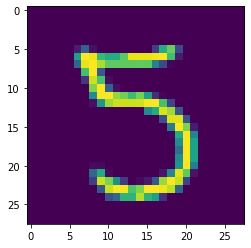

In [218]:
plt.imshow(xb[0].view(28, 28))

#### multiprocessing dataloader

In [219]:
import torch.multiprocessing as mp

In [223]:
train_ds[[0, 1, 2]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4]))

In [229]:
train_ds.__getitem__([0, 9, 3])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 4, 1]))

In [232]:
for o in map(train_ds.__getitem__, ([0, 3], [4, 5])):
             print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([9, 2]))
